In [2]:
import numpy as np
import control as ct
import sympy as sp
from matplotlib import pyplot as plt
%matplotlib inline

N = 5.5
plt.rcParams['figure.figsize'] = (N*1.285, N)

## Práctica calificada 2 - Teoría de Control 2020 - UTEC
### Alumno: Bregy Malpartida

In [3]:
# Estas son mis funciones útiles para poder realizar diseño de controladores en python, 
# todas las he escrito yo, y conozco su principio de funcionamiento.

def sym_transfer_function(eq):
    s = sp.var('s')
    used_symbols = [str(l) for l in eq.free_symbols]
    if not len(used_symbols) == 1 or not "s" in used_symbols:
        raise Exception("invalid equation, please use correct transfer function equation (e.g. 1/(s**2+3))")
    n, d = sp.fraction(sp.factor(eq))
    num = sp.Poly(sp.expand(n), s).all_coeffs()
    den = sp.Poly(sp.expand(d), s).all_coeffs()
    num = [float(v) for v in num]
    den = [float(v) for v in den]
    
    return ct.TransferFunction(num, den)

def extract_characteristic_equation(K, G, H):
    num, _ = sp.fraction(sp.simplify(1 + K*G*H))
    return sp.expand(num) # == 0

def construct_poles(psi, wn):
    i_part = wn*np.sqrt(1-psi**2)
    p1 = -psi*wn + 1j*i_part
    p2 = -psi*wn - 1j*i_part
    return [p1, p2]

def from_quality_to_psi_wn(po, ts):
    # po = percentage overshoot
    po_log = np.log(po/100)**2
    psi = np.sqrt(po_log/(np.pi**2 + po_log))
    wn = 4/psi/ts
    return psi, wn

def gain_to_poles(K, G, H, gain, once=-1):
    eq = extract_characteristic_equation(K, G, H)
    s = sp.var("s")
    
    poles = sp.solve(eq, s) # a.k.a roots in function of K
    current_poles = [complex(sp.N(p, chop=True).subs(K, gain)) for p in poles] # K == 0
    
    return current_poles if once < 0 else current_poles[once % len(current_poles)]

def pole_to_psi_wn(pole):
    psi, wn = sp.var("psi w_n")
    
    pole = complex(pole)
    
    # p1 = psi*wn +/- j*wn*sqrt(1-psi^2)
    eq1 = sp.Eq(-psi*wn, pole.real)
    eq2 = sp.Eq(wn*sp.sqrt(1 - psi**2), pole.imag)
    
    result = sp.solve([eq1, eq2], (psi, wn))

    psi_v, wn_v = 0.0, 0.0
    
    if len(result) < 2:
        psi_v, wn_v = result[0]
    else:
        psi_v, wn_v = result[1]

    return float(psi_v), float(wn_v)

def point_report(pole):
    psi, wn = pole_to_psi_wn(pole)
    po = 100*np.exp(-psi*np.pi/np.sqrt(1-psi**2))
    
    print("Pole: %.3f + %.3fi"%(pole.real, pole.imag))
    print("Damping: %.3f"%psi)
    print("Overshoot (%%): %.0f"%po)
    print("Frequency (rad/s): %.3f"%wn)
    
def step_report(t, y_out):
    try:
        print("PO: %.3f%%"%((y_out.max()/y_out[-1]-1)*100))
        print("Tr: %.3f s"%(t[next(i for i in range(0,len(y_out)-1) if y_out[i]>y_out[-1]*.90)]-t[0]))
        print("Ts: %.3f s"%(t[next(len(y_out)-i for i in range(2,len(y_out)-1) if abs(y_out[-i]/y_out[-1])>1.02)]-t[0]))
    except:
        pass
    
def plot_root_locus(K, G, H, ki=0, kf=30, points=400, find_k=[], print_critical=False, tolerance=0.05):
    plt.title(f"Root locus of $G={sp.latex(G)}$", fontsize='x-large')
    plt.xlabel("$Real\ Axis\ [s^{-1}]$")
    plt.ylabel("$Imaginary\ Axis\ [s^{-1}]$")
    
    eq = extract_characteristic_equation(K, G, H)
    s = sp.var("s")
    
    poles = sp.solve(eq, s) # a.k.a roots in function of K
    poles_points = []
    founds = []
    for p in poles:
        pole_points = []
        for k in np.linspace(ki, kf, points):
            point = complex(sp.N(p, chop=True).subs(K, k))
            if print_critical and abs(point.real) < 0.001 and abs(point) > 0.001:
                print("Critical gain K = %.3f at %.3f + %.3fi"%(k, point.real, point.imag))
            np_find = np.array(find_k)
            for found in np_find[np.abs(k - np_find) < tolerance]:
                founds.append(point)
            pole_points.append(point)
        poles_points.append(pole_points)
    
    # gains_points = [[(k, complex(sp.N(p, chop=True).subs(K, k))) for k in np.linspace(ki, kf, points)] for p in poles]

    plt.axvline(0, color='k')
    plt.axhline(0, color='k')
    plt.grid()
    
    for pole in poles_points:
        # changing dimention
        reals, imags = [], []
        for point in pole:
            angle = np.angle(point)*2*180/2/np.pi
            reals.append(point.real)
            imags.append(point.imag)

        plt.plot(reals, imags)
    
    current_pole = [complex(sp.N(p, chop=True).subs(K, 0)) for p in poles] # K == 0
    reals, imags = [], []
    
    for point in current_pole:
        reals.append(float(point.real))
        imags.append(float(point.imag))

    plt.scatter(reals, imags)


def find_point_in_root_locus(K, G, H, ki=0, kf=30, points=400, find=[], tolerance=0.1, print_founds=False):
    eq = extract_characteristic_equation(K, G, H)
    s = sp.var("s")
    
    poles = sp.solve(eq, s) # a.k.a roots in function of K
    poles_points = []
    founds = []
    for p in poles:
        pole_points = []
        for k in np.linspace(ki, kf, points):
            point = complex(sp.N(p, chop=True).subs(K, k))
            for to_find in find:
                c1 = np.abs(to_find.real - point.real) < tolerance
                c2 = np.abs(to_find.imag - point.imag) < tolerance
                if c1 and c2:
                    if print_founds:
                        e = np.mean([np.abs(to_find.real - point.real), np.abs(to_find.imag - point.imag)])
                        print("K = %.3f at %.3f + %.3fi | e = %.3f"%(k, point.real, point.imag, e))
                    founds.append((k, point))
            pole_points.append(point)
        poles_points.append(pole_points)
    
    return founds

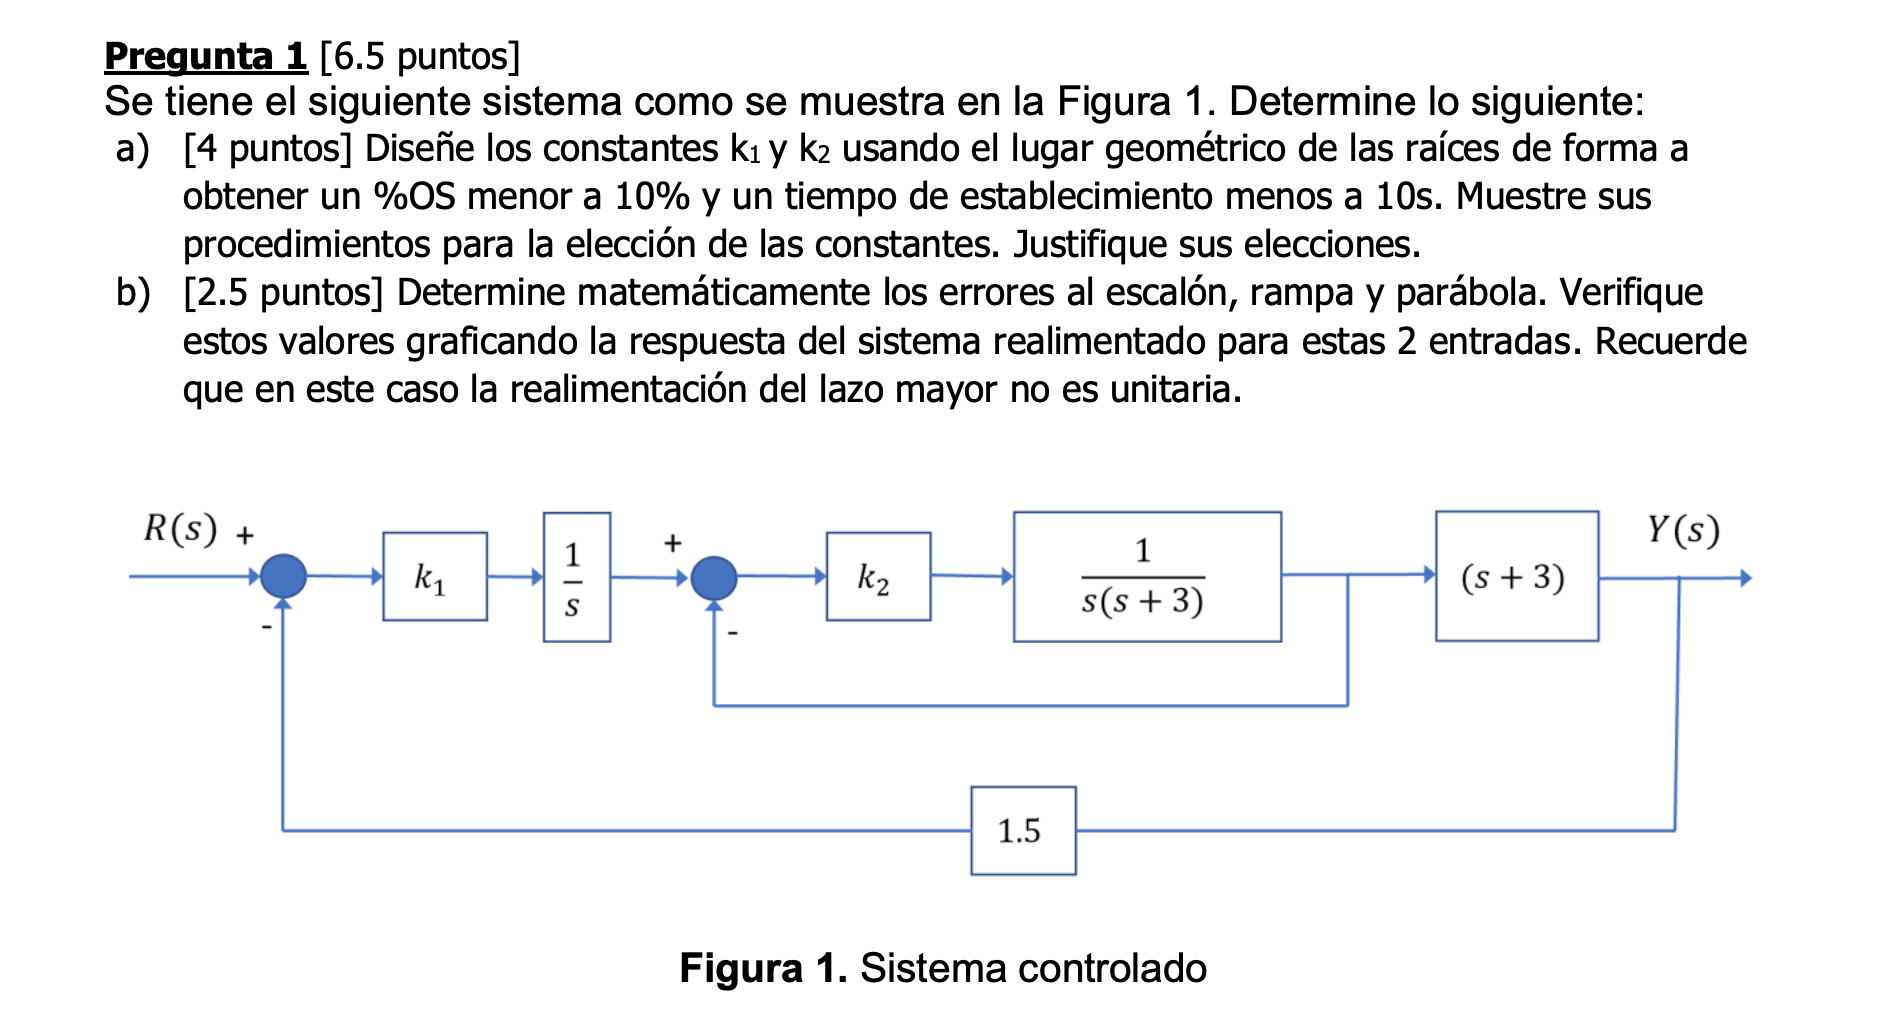

### a)  Diseñe los constantes k1 y k2 usando el lugar geométrico de las raíces de forma a obtener un %OS menor a 10% y un tiempo de establecimiento menos a 10s. Muestre sus procedimientos para la elección de las constantes. Justifique sus elecciones.

In [54]:
s = sp.var("s")
k1, k2 = sp.var("k_1 k_2")

inner= k2 * 1/s/(s+3)
looped_inner = inner/(1+inner)
total_tf = k1 * 1/s * looped_inner * (s+3)

total_tf = sp.factor(total_tf)
total_tf

k_1*k_2*(s + 3)/(s*(k_2 + s**2 + 3*s))

Ahora, necesitamos relacionar k1 y k2 para obtener un sistema tipo K(s)*G(s)\

Debido a que k2 no puede salir del denominador, trataré de darle un valor fijo y luego propagaré su valor al numerador y con eso conseguir la forma necesaria para construir el controlador


In [52]:
static_k2 = 1
fixed_tf = total_tf.subs(k2, static_k2)
fixed_tf

k_1*(s + 3)/(s*(s**2 + 3*s + 1))

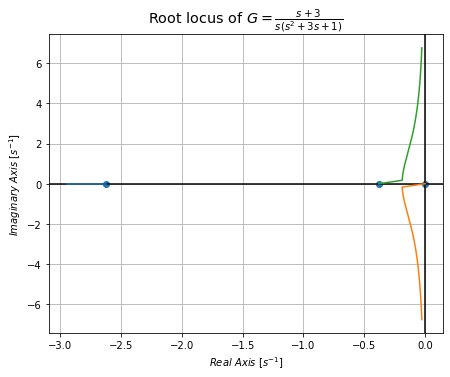

In [26]:
K = sp.var("K")
G = fixed_tf.subs(k1, 1) # para quitar el K
H = 1.5
# graficando el root locus
plot_root_locus(K, G, H, points=800)

Diseñando para PO < 10% y Ts < 10s\
Reduciendo un poco las especificaciones usaré $po = 0.8$ y $t_s = 8$

In [34]:
po = 0.8 
ts = 8

psi, wn = from_quality_to_psi_wn(po, ts)
print(f"psi= {psi} | ws= {wn}")

expected_poles = construct_poles(psi, wn) # estos son los polos parametrizados

_ = find_point_in_root_locus(K, G, H, find=expected_poles, tolerance=0.35, print_founds=True)

psi= 0.838190581428381 | ws= 0.5965230474767896
K = 0.075 at -0.187 + -0.306i | e = 0.166
K = 0.150 at -0.184 + -0.472i | e = 0.232
K = 0.226 at -0.181 + -0.593i | e = 0.294
K = 0.000 at -0.382 + -0.000i | e = 0.222
K = 0.000 at -0.382 + -0.000i | e = 0.222
K = 0.075 at -0.187 + 0.306i | e = 0.166
K = 0.150 at -0.184 + 0.472i | e = 0.232
K = 0.226 at -0.181 + 0.593i | e = 0.294


La función "find_point_in_root_locus" busca polos cercanos a los que se le pasan por el argumento "find", para dicho fin se usa el path generado por el root locus

OS: 14.500%
Tr: 6.414 s
Ts: 15.847 s


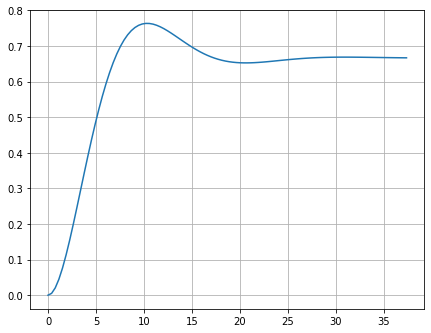

In [48]:
k1 = 0.075
k2 = 1

Gn = k1*k2*(s+3)/s/(s**2+3*s+k2)
tf = sym_transfer_function(Gn)
tf = ct.feedback(tf, 1.5)
t, y = ct.step_response(tf)
step_report(t, y)
plt.grid()
plt.plot(t, y);

Como se puede apreciar, las constantes $k_1 = 0.075$ y $k_2 = 1$ no satisfacen el requerimiento exigido, por ende, haré un cambio a $k_2$, esta vez tendrá un valor mayor: $k_2 = 2$

In [76]:
k1, k2 = sp.var("k_1 k_2")

fixed_tf_new = total_tf.subs(k2, 4) # k2 = 0.5

display(fixed_tf_new)

K_new = sp.var("K")
G_new = fixed_tf_new.subs(k1, 1) # para quitar el K
H_new = 1.5

po = 0.8
ts = 8

psi, wn = from_quality_to_psi_wn(po, ts)
print(f"psi= {psi} | ws= {wn}")

expected_poles = construct_poles(psi, wn) # estos son los polos parametrizados
print(expected_poles)

_ = find_point_in_root_locus(K_new, G_new, H_new, find=expected_poles, tolerance=0.45, print_founds=True)

4*k_1*(s + 3)/(s*(s**2 + 3*s + 4))

psi= 0.838190581428381 | ws= 0.5965230474767896
[(-0.5+0.32533021097186193j), (-0.5-0.32533021097186193j)]
K = 0.075 at -0.396 + 0.000i | e = 0.215
K = 0.075 at -0.396 + 0.000i | e = 0.215
K = 0.150 at -0.898 + 0.000i | e = 0.362
K = 0.150 at -0.898 + 0.000i | e = 0.362


OS: 1.384%
Tr: 5.438 s


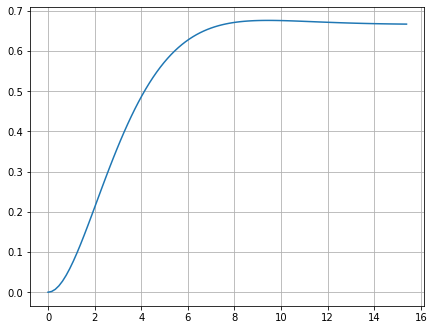

In [77]:
k1 = 0.075
k2 = 2

Gn = k1*k2*(s+3)/s/(s**2+3*s+k2)

tf = sym_transfer_function(Gn)
tf = ct.feedback(tf, 1.5)

t, y = ct.step_response(tf)
step_report(t, y)
plt.grid()
plt.plot(t, y);

Finalmente, habiendo fijado el valor de $k2 = 2$ y usando el lugar geométrico de las raices, \
pude conseguir un sistema que se ajusta a los requerimientos planteados por el problema.

Los valores elegidos fueron
$$ k_1 = 0.075 \ y \ k_2 = 2 $$ 

El sistema en estado estable tiene error, pero los requerimientos solicitados se estan cumpliendo, tiene un $OS = 1.384$ y un $T_s \approx 8 $

### Determine matemáticamente los errores al escalón, rampa y parábola. Verifique estos valores graficando la respuesta del sistema realimentado para estas 2 entradas. Recuerde que en este caso la realimentación del lazo mayor no es unitaria.

La variable "tf" ya tiene la función de transferencia con el lazo mayor no unitario

In [90]:
tf


        0.15 s + 0.45
-----------------------------
s^3 + 3 s^2 + 2.225 s + 0.675

Para determinar el error de cada función solicitada simplemente restaré el valor en estado estacionario (output) con el del esperado (input), el código de abajo solo construye la simulación en un rango t y uStep, uRamp y uParabola tienen los valores de entrada mientras que los resultados de cada uno se guardan en "y"

Error al escalon = 0.3325960362290946
Error a la rampa = 6.97522665712761
Error a la velocidad = 63.583891291401876
---


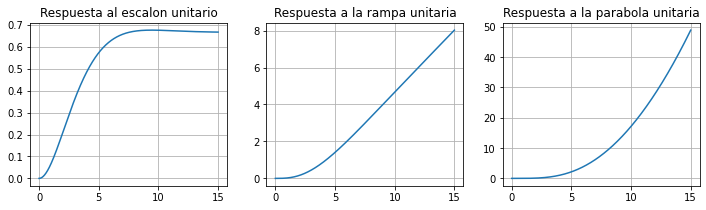

In [108]:
t = np.linspace(0, 15, 1000)

uStep = np.ones_like(t) # unitStep
uRamp = t # t
uParabol = 1/2*t**2

plt.figure(figsize=(12, 3))

t, y, x0 = ct.forced_response(tf, t, uStep)
err_step = np.abs(y[-1] - uStep[-1]) # los últimos valores ("los más estacionarios")

plt.subplot(131)
plt.grid()
plt.title("Respuesta al escalon unitario")
plt.plot(t, y)

t, y, x0 = ct.forced_response(tf, t, uRamp)
err_ramp = np.abs(y[-1] - uRamp[-1]) # los últimos valores ("los más estacionarios")

plt.subplot(132)
plt.grid()
plt.title("Respuesta a la rampa unitaria")
plt.plot(t, y)

t, y, x0 = ct.forced_response(tf, t, uParabol)
err_parabol = np.abs(y[-1] - uParabol[-1]) # los últimos valores ("los más estacionarios")

plt.subplot(133)
plt.grid()
plt.title("Respuesta a la parabola unitaria")
plt.plot(t, y);

print("Error al escalon = {}".format(np.real(err_step)))
print("Error a la rampa = {}".format(np.real(err_ramp)))
print("Error a la velocidad = {}".format(np.real(err_parabol)))
print("---")

Finalmente, los errors son:
$$ e_{step} \approx 0.33 $$
$$ e_{ramp} \approx 6.97 $$
$$ e_{parabol} \approx 6.58 $$

---

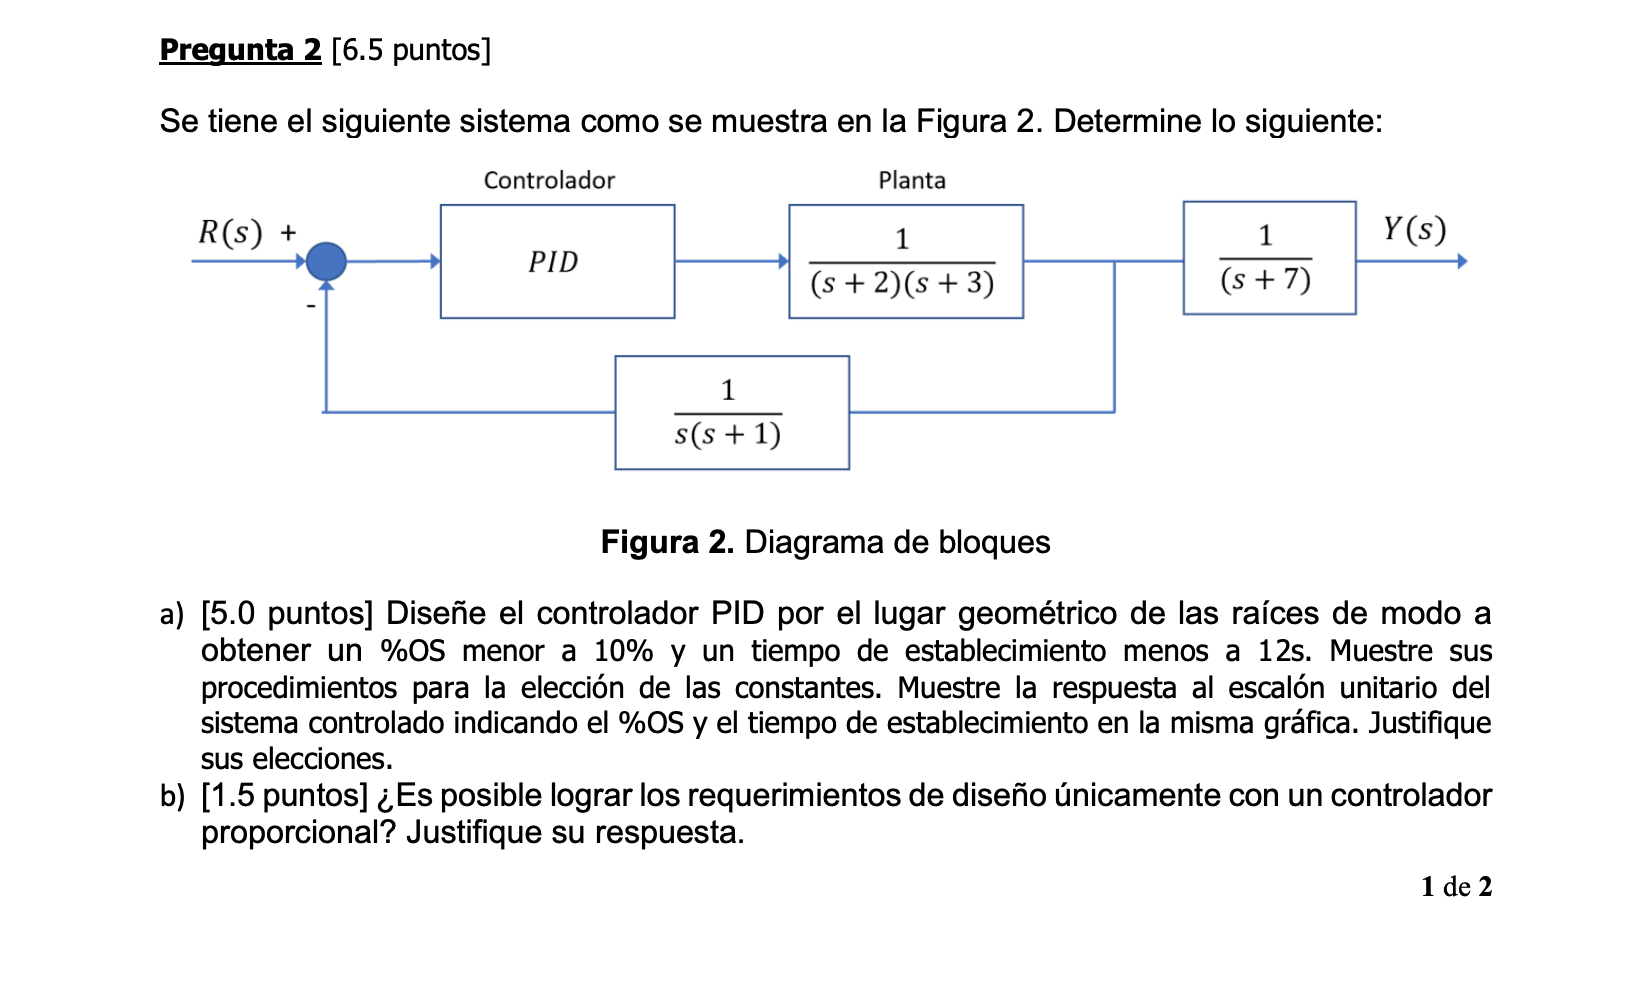

Según las últimas indicaciones consideraré $$ H(s) = \frac{1}{s+1} $$

Para simplificar el desarrollo del sistema haré una conversión a un sistema equivalente, pasaré el bloque $\frac{1}{s+7}$ a la parte interna del bloque superior, para lograrlo, dividiré $\frac{1}{s+7}$ al bloque inferior (de feedback). 

Quedando...

In [101]:
pid = sp.var("PID")

plant = 1/(s+2)/(s+3)
h = 1/(s+1)
outer = 1/(s+7)

G = sp.simplify(pid*plant*outer)
H = sp.simplify(h/outer)

display(G)
display(H)

PID/((s + 2)*(s + 3)*(s + 7))

(s + 7)/(s + 1)

Construyendo el PID

In [102]:
Kc, a, b = sp.var("Kc a b")

G.subs(pid, Kc*(s+a)*(s+b)/s)

Kc*(a + s)*(b + s)/(s*(s + 2)*(s + 3)*(s + 7))

In [115]:
po = 0.05 # < 1%
ts = 8 # < 12s

psi, wn = from_quality_to_psi_wn(po, ts)
print(f"psi= {psi} | ws= {wn}")

pds = construct_poles(psi, wn)

print("\nLos polos deseados son:")
print(pds)

psi= 0.9241717597800003 | ws= 0.5410249715042421

Los polos deseados son:
[(-0.49999999999999994+0.20665918753146692j), (-0.49999999999999994-0.20665918753146692j)]


Partiendo de que $a = b$

In [118]:
pd = pds[0]
poles_sys = np.array([0, -2, -3, -7])

poles_angles = np.angle(pd - poles_sys)*180/np.pi

Aplicando la condición de módulo puedo hayar b

In [154]:
# suma de todos los angulos de los polos
p_sum = np.sum(poles_angles)

# angulo de b
b_angle = (-180 + 360 + p_sum)/2

d = pd.imag/np.tan(b_angle*np.pi/180);
b_val = pd.real - d;

In [155]:
b_val

2.4313860367903173

Ahora, usando la definicieon de la condición de módulo puedo conseguir Kc

In [159]:
z1 = pd - b_val
poles_distances = np.abs(pd - poles_sys)

kc_val = np.prod(poles_distances)/np.abs(z1)/np.abs(z1) # 2 veces la dist del polo deseado

In [160]:
kc_val

1.54754776208571

In [163]:
Kc, a, b = sp.var("Kc a b")
G_pid = G.subs(pid, Kc*(s+a)*(s+b)/s)
# display(G_pid)
G_pid = G_pid.subs(a, b_val)
G_pid = G_pid.subs(b, b_val)
G_pid = G_pid.subs(Kc, kc_val)
print("Control + Systema final")
display(G_pid)

Control + Systema final


9.14854224985729*(0.411288041005658*s + 1)**2/(s*(s + 2)*(s + 3)*(s + 7))


          0.1144 s^2 + 0.5564 s + 0.6764
--------------------------------------------------
0.07394 s^4 + 0.4436 s^3 + 0.9277 s^2 + s + 0.6764

OS: 24.765%
Tr: 1.723 s
Ts: 4.308 s


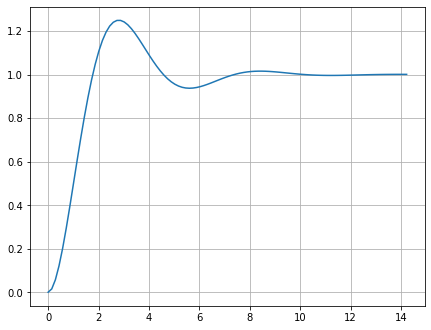

In [170]:
# respuesta al escalon

sys_symbolic = G_pid*H/(1 + G_pid*H)
sys = sym_transfer_function(sys_symbolic)

display(sys)

t, y = ct.step_response(sys)
plt.grid()
plt.plot(t, y);
step_report(t, y)